# Analyse des PAN aux USA, au Royaume-Uni et au Canada

# Communiquez vos résultats - partie 4
# Analyse des relations des phénomènes avec la population

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importation-et-lecture-du-fichier-population-et-du-fichier-principal-des-pays-étudiés" data-toc-modified-id="Importation-et-lecture-du-fichier-population-et-du-fichier-principal-des-pays-étudiés-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importation et lecture du fichier <code>population</code> et du fichier principal des pays étudiés</a></span><ul class="toc-item"><li><span><a href="#Description-du-fichier-population" data-toc-modified-id="Description-du-fichier-population-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Description du fichier <code>population</code></a></span></li></ul></li><li><span><a href="#Analyses-des-variables" data-toc-modified-id="Analyses-des-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analyses des variables</a></span><ul class="toc-item"><li><span><a href="#Analyse-univariée" data-toc-modified-id="Analyse-univariée-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Analyse univariée</a></span></li><li><span><a href="#Analyses-bivariées" data-toc-modified-id="Analyses-bivariées-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Analyses bivariées</a></span><ul class="toc-item"><li><span><a href="#Test-d'ANOVA" data-toc-modified-id="Test-d'ANOVA-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Test d'ANOVA</a></span></li><li><span><a href="#Corrélation-entre-les-différentes-variables-selon-la-méthode-de-Pearson" data-toc-modified-id="Corrélation-entre-les-différentes-variables-selon-la-méthode-de-Pearson-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Corrélation entre les différentes variables selon la méthode de Pearson</a></span></li></ul></li></ul></li><li><span><a href="#Etude-l'impact-de-la-population--sur-les-phénomènes" data-toc-modified-id="Etude-l'impact-de-la-population--sur-les-phénomènes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Etude l'impact de la <code>population</code>  sur les phénomènes</a></span><ul class="toc-item"><li><span><a href="#United-Kingdom" data-toc-modified-id="United-Kingdom-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>United Kingdom</a></span></li><li><span><a href="#Etat-Unis" data-toc-modified-id="Etat-Unis-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Etat-Unis</a></span></li><li><span><a href="#Canada" data-toc-modified-id="Canada-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Canada</a></span></li></ul></li></ul></div>

Importation des librairies nécessaires à l'exécution du code

In [1]:
# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly
import plotly.express as px
import json
from datetime import datetime
import re
import datetime

# Librairies statistiques
from scipy.stats import chi2_contingency
import scipy.stats as stats
from scipy.stats import ks_2samp

# Librairies visualisation
from folium import Choropleth
from folium.plugins import HeatMap
from urllib.request import urlopen

import plotly.figure_factory as ff
import plotly.io as pio
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode, download_plotlyjs
# jupyter set up
init_notebook_mode(connected=True)

In [2]:
#  version de pandas
print(f'version pandas : {pd.__version__}')
#  version de numpy
print(f'version numpy : {np.__version__}')
#  version de folium
print(f'version folium : {folium.__version__}')
# version de plotly
print(f'version plotly : {plotly.__version__}')
#  version de plotly express
# print(f'version plotly express : {px.__version__}')

version pandas : 1.1.3
version numpy : 1.19.2
version folium : 0.12.1
version plotly : 4.14.3


In [3]:
ENCODAGE = 'UTF-8'

In [4]:
TEMPLATE = 'plotly_dark'

In [5]:
COLORS = {'Canada':'#fdca26',
          'United Kingdom':'#35b779',
          'USA':'#0d0887'}

In [6]:
COLOR_EVOLUTION = 'Plasma_r'
COLOR_UFO_SHAPE = px.colors.sequential.Mint
COLOR_UFO_DURATION = px.colors.sequential.Blues

In [7]:
sns.set(style="darkgrid")

In [8]:
def ks_2samp_test(col, df):
    """Test de Kolmogorov-Smirnov 
    Test d'adéquation à une loi normale.
    
    Parameters
    ----------
    col : variable à tester
    df : dataset étudié
    
    Le seuil alpha est fixé à 0.05
    
    Returns
    -------
    Un message indiquant la normalité ou non de la variable
    """
    
    alpha = 0.05
    stat, p_value = ks_2samp(df[col],
                             list(np.random.normal(np.mean(df[col]),
                                                   np.std(df[col]),
                                                   1000)
                                 )
                            )
    print(f'p_value :{p_value}')
    
    if p_value < alpha :
        return(f'HO rejetée, la variable {col} ne suit pas une loi normale')
    else :
        return (f'HO ne peut pas être rejetée, la variable {col} suit une loi NORMALE')

In [9]:
def eta_squared(df, X, Y):
    """Calcul de l'éta carré.
    Permet de calculer le rapport de corrélation.
        
    Parameters
    ----------
    df : dataset
    X : variable qualitative
    Y : variable quantitative
    
    Returns
    -------
    rapport de corrélation
    SCE/SCT    
    """
    
    sous_echantillon = df.copy()
    x = sous_echantillon[X]
    y = sous_echantillon[Y]
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x == classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

## Importation et lecture du fichier `population` et du fichier principal des pays étudiés

On travaille que sur les pays les plus représentés à savoir les USA, le Canada et l'Angleterre

Importation du fichier principal

In [10]:
df_ufo = pd.read_csv("df_ufo.csv", encoding=ENCODAGE)

Importation du fichier population

In [11]:
df_pop = pd.read_csv("pop_us_ca_gb_clean.csv", encoding=ENCODAGE)

### Description du fichier `population` 

Dimension du dataset `df_pop`

In [12]:
df_pop.shape

(81, 3)

In [13]:
df_pop.describe()

population
count  8.100000e+01
mean   5.431056e+06
std    6.412800e+06
min    3.928500e+04
25%    1.177884e+06
50%    3.959353e+06
75%    6.910840e+06
max    3.953822e+07

Jointure du dataset df_pop avec df_ufo pour récupérer le nombre d'habitants de chaque état

In [14]:
df_ufo_pop_tot = pd.merge(df_ufo, df_pop, how="left")

Aucune valeur null

In [15]:
df_ufo_pop_tot.isnull().sum()

dates_time                         0
city                               0
state/province                     0
country                            0
UFO_shape                          0
length_of_encounter_seconds        0
latitude                           0
longitude                          0
state                              0
year                               0
month                              0
hour                               0
day                                0
cat_UFO_shape                      0
log_length_of_encounter_seconds    0
gpe_duration                       0
population                         0
dtype: int64

Dataset créé : `df_ufo_pop_tot`

In [16]:
df_ufo_pop_tot.head(2)

dates_time     city state/province         country UFO_shape  \
0  1955-10-10 17:00:00  Chester             CH  United Kingdom    circle   
1  1965-10-10 21:00:00  Penarth             CF  United Kingdom    circle   

   length_of_encounter_seconds   latitude  longitude                  state  \
0                         20.0  53.200000  -2.916667  North West of England   
1                        180.0  51.434722  -3.180000                  Wales   

   year  month  hour  day cat_UFO_shape  log_length_of_encounter_seconds  \
0  1955     10    17    0   ovoid_shape                         2.995732   
1  1965     10    21    6   ovoid_shape                         5.192957   

  gpe_duration  population  
0         <60s     7341196  
1      61-300s     3152879

Dimension du dataset

In [17]:
df_ufo_pop_tot.shape

(67274, 17)

Export du dataset `df_ufo_pop_tot` en csv 

In [18]:
df_ufo_pop_tot.to_csv("df_ufo_pop_tot.csv", index=False, encoding=ENCODAGE)

## Analyses des variables

### Analyse univariée

Type des variables

In [19]:
df_ufo_pop_tot.dtypes

dates_time                          object
city                                object
state/province                      object
country                             object
UFO_shape                           object
length_of_encounter_seconds        float64
latitude                           float64
longitude                          float64
state                               object
year                                 int64
month                                int64
hour                                 int64
day                                  int64
cat_UFO_shape                       object
log_length_of_encounter_seconds    float64
gpe_duration                        object
population                           int64
dtype: object

Aucune valeur manquante

In [20]:
df_ufo_pop_tot.isnull().sum()

dates_time                         0
city                               0
state/province                     0
country                            0
UFO_shape                          0
length_of_encounter_seconds        0
latitude                           0
longitude                          0
state                              0
year                               0
month                              0
hour                               0
day                                0
cat_UFO_shape                      0
log_length_of_encounter_seconds    0
gpe_duration                       0
population                         0
dtype: int64

In [21]:
df_ufo_pop_tot.select_dtypes(['int64', 'float64']).columns

Index(['length_of_encounter_seconds', 'latitude', 'longitude', 'year', 'month',
       'hour', 'day', 'log_length_of_encounter_seconds', 'population'],
      dtype='object')

Quelques mesures statistiques

In [22]:
v_quanti = df_ufo_pop_tot.select_dtypes(['int64', 'float64']).columns

for variable in v_quanti:
    print("-"*20)
    print(f'skewness {variable}:\n', df_ufo_pop_tot[variable].skew())
    print(f"kurtosis {variable}:\n", df_ufo_pop_tot[variable].kurtosis())
    print(f"mode {variable}:\n", df_ufo_pop_tot[variable].mode())
    ske = round(df_ufo_pop_tot[variable].skew(), 2)
    kur = round(df_ufo_pop_tot[variable].kurtosis(), 2)
plt.show()

--------------------
skewness length_of_encounter_seconds:
 1.8432727069640467
kurtosis length_of_encounter_seconds:
 2.860134402481108
mode length_of_encounter_seconds:
 0    300.0
dtype: float64
--------------------
skewness latitude:
 -0.0953946622421085
kurtosis latitude:
 3.4622942113438877
mode latitude:
 0    47.606389
dtype: float64
--------------------
skewness longitude:
 1.2011276867204324
kurtosis longitude:
 4.979758793209248
mode longitude:
 0   -122.330833
dtype: float64
--------------------
skewness year:
 -2.4209166849686694
kurtosis year:
 7.209927210059217
mode year:
 0    2012
dtype: int64
--------------------
skewness month:
 -0.20814804790309047
kurtosis month:
 -0.9725974353381246
mode month:
 0    7
dtype: int64
--------------------
skewness hour:
 -0.9955764593434007
kurtosis hour:
 -0.5271746003030437
mode hour:
 0    21
dtype: int64
--------------------
skewness day:
 -0.11972999298174722
kurtosis day:
 -1.244892226361872
mode day:
 0    5
dtype: int64
------

Variables quantitatives

In [23]:
v_quanti

Index(['length_of_encounter_seconds', 'latitude', 'longitude', 'year', 'month',
       'hour', 'day', 'log_length_of_encounter_seconds', 'population'],
      dtype='object')

Test de Kolmogorov-Smirnov pour tester l'adéquation à une loi normale des variables

In [24]:
for variable in v_quanti :
    print(f'{variable :-<32}{ks_2samp_test(variable, df_ufo_pop_tot)}\n') 

p_value :1.4201547950466985e-52
length_of_encounter_seconds-----HO rejetée, la variable length_of_encounter_seconds ne suit pas une loi normale

p_value :0.0021590350679682223
latitude------------------------HO rejetée, la variable latitude ne suit pas une loi normale

p_value :6.2281607464940715e-15
longitude-----------------------HO rejetée, la variable longitude ne suit pas une loi normale

p_value :2.779306756648872e-31
year----------------------------HO rejetée, la variable year ne suit pas une loi normale

p_value :6.5540883917649715e-09
month---------------------------HO rejetée, la variable month ne suit pas une loi normale

p_value :3.227637007121372e-42
hour----------------------------HO rejetée, la variable hour ne suit pas une loi normale

p_value :1.0263463138222778e-17
day-----------------------------HO rejetée, la variable day ne suit pas une loi normale

p_value :1.3268115464424902e-15
log_length_of_encounter_seconds-HO rejetée, la variable log_length_of_encounter_secon

Compte tenu du grand nombre d'observation, on peut considérer que les variables suivent une loi gaussienne

### Analyses bivariées

Corrélation entre le nombre de phénomènes (`cat_UFO_shape`) et le nombre d'habitants (`population`)

#### Test d'ANOVA

Le nombre d'habitant est-il dépendant ou non du nombre de phénomènes observés ?

In [25]:
df_ufo_pop_tot.head(2)

dates_time     city state/province         country UFO_shape  \
0  1955-10-10 17:00:00  Chester             CH  United Kingdom    circle   
1  1965-10-10 21:00:00  Penarth             CF  United Kingdom    circle   

   length_of_encounter_seconds   latitude  longitude                  state  \
0                         20.0  53.200000  -2.916667  North West of England   
1                        180.0  51.434722  -3.180000                  Wales   

   year  month  hour  day cat_UFO_shape  log_length_of_encounter_seconds  \
0  1955     10    17    0   ovoid_shape                         2.995732   
1  1965     10    21    6   ovoid_shape                         5.192957   

  gpe_duration  population  
0         <60s     7341196  
1      61-300s     3152879

Catégories d'UFO_shape (`cat_UFO_shape`)

In [26]:
df_ufo_pop_tot.cat_UFO_shape.unique()

array(['ovoid_shape', 'cylinder_shape', 'angular_shape',
       'formation_shape', 'changing_shape', 'other_shape', 'light_shape'],
      dtype=object)

Création des groupes

In [27]:
gp_ovoid_shape = df_ufo_pop_tot[df_ufo_pop_tot['cat_UFO_shape']
                                == 'ovoid_shape']['population']

In [28]:
gp_cylinder_shape = df_ufo_pop_tot[df_ufo_pop_tot['cat_UFO_shape']
                                   == 'cylinder_shape']['population']

In [29]:
gp_light_shape = df_ufo_pop_tot[df_ufo_pop_tot['cat_UFO_shape']
                                == 'light_shape']['population']

Tests d'hypothèse  
H0 : les moyennes des groupes sont égales  
H1 : au moins une moyenne des groupes est différentes  
seuil alpha : 0.05

In [30]:
# Stats f_oneway functions takes the groups as input
# Returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(gp_ovoid_shape,
                                gp_cylinder_shape,
                                gp_light_shape)                                
print(f'f_value {fvalue}, p_value : {pvalue}')

f_value 6.811130392163215, p_value : 0.0011026157488429516


La p_value est significativement plus petite que le seuil alpha de 0.05%  
L'hypothèse H0 d'égalité des moyennes est rejetée.  
Ainsi, nous pouvons en conclure que le nombre d'habitant influe sur les phénomènes

#### Corrélation entre les différentes variables selon la méthode de Pearson

Tableau de corrélation 

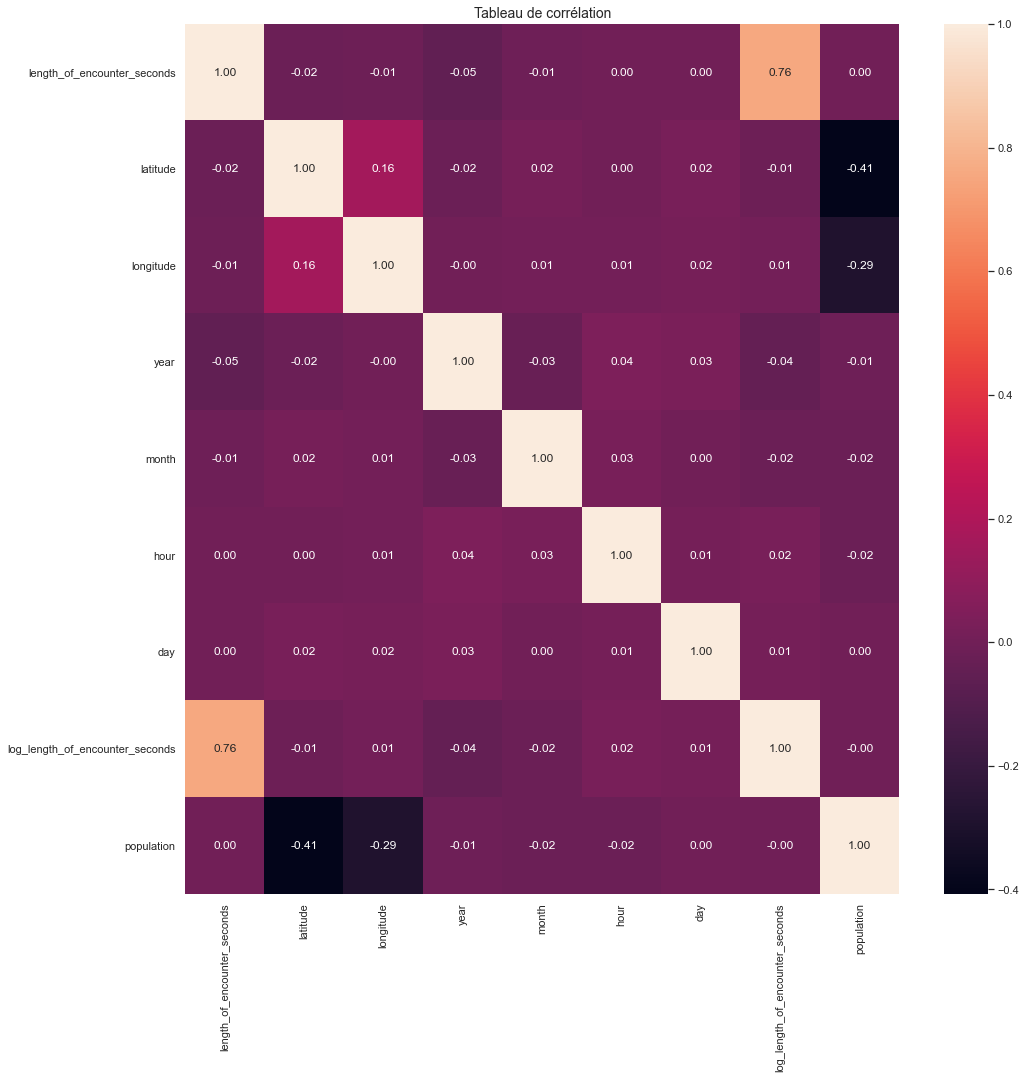

In [31]:
# Corrélation entre les variables
plt.figure(figsize=(16, 16))
sns.heatmap(df_ufo_pop_tot.corr(method='pearson'),
            annot=True,
            fmt=".2f")
plt.title('Tableau de corrélation', size=14)
# plt.show()
plt.savefig('Tableau de corrélation population.jpg')

On observe une corrélation entre la population et la latitude

## Etude l'impact de la `population`  sur les phénomènes

Pays concernés : USA, Canada et UK

Regroupement par état

In [32]:
df_pop_state_ufo = df_ufo_pop_tot.groupby(
    ["state",
     "population", "country"]
).agg(
    latitude=("latitude", "mean"),
    longitude=("longitude", "mean"),
    count_ufo_shape=("cat_UFO_shape", "count")
).reset_index()

In [33]:
df_pop_state_ufo.head(2)

state  population country   latitude   longitude  count_ufo_shape
0  Alabama     5024279     USA  33.052157  -86.381869              594
1   Alaska      733391     USA  61.671696 -149.115485              295

Création de la colonne de proportion `ufo_pop (100000 hb)`qui correspond au nombre de phénomènes pour 100000 habitants

In [34]:
df_pop_state_ufo['ufo_pop (100000 hb)'] = df_pop_state_ufo["count_ufo_shape"]/df_pop_state_ufo['population']*100000

Distribution du nombre de phénomènes pour 100000 habitants en fonction des états

In [35]:
df_pop_state_ufo.head(2)

state  population country   latitude   longitude  count_ufo_shape  \
0  Alabama     5024279     USA  33.052157  -86.381869              594   
1   Alaska      733391     USA  61.671696 -149.115485              295   

   ufo_pop (100000 hb)  
0            11.822592  
1            40.224110

plotly

In [36]:
#  Graph
fig = px.bar(df_pop_state_ufo,
             y='ufo_pop (100000 hb)',
             x='state',
             labels={'ufo_pop (100000 hb)': 'Nombre de phénomènes<br>'
                     '<sup>(pour 100 000 habitants)</sup>',
                     'state': 'Etat'},
             color="ufo_pop (100000 hb)",
             color_continuous_scale="Viridis_r",
             template=TEMPLATE)

# Text
fig.update_layout(title='Nombre de phénomènes par Etat<br>'
                  '<sup>Canada, USA, United Kingdom</sup>',
                  showlegend=True,
                  xaxis=dict(
                        showline=True,
                        showgrid=True,
                        showticklabels=True,
                        linecolor='rgb(204, 204, 204)',
                        linewidth=2,
                        ticks='outside',
                        tickfont=dict(
                            family='Arial',
                            size=12,
                            color='rgb(82, 82, 82)'
                        ),
                  ),
                  yaxis=dict(
                      showgrid=True,
                      zeroline=False,
                      showline=False,
                      showticklabels=True,
                      tickfont=dict(
                          family='Arial',
                          size=12,
                          color='rgb(82, 82, 82)'
                      ),
                  )
                  #                   plot_bgcolor='white'
                  )

# Annotations
annotations = []

# Graph annotation
annotations.append(dict(xref='x', yref='y', 
                        x=48, y=109,
                        text="max=109",
                        showarrow=True,
                        font=dict(
                            family="Arial, monospace",
                            size=14,
                            color="#ffffff"
                        ),
                        align="center",
                        arrowhead=2,
                        arrowsize=1,
                        arrowwidth=2,
                        arrowcolor="#636363",
                        ax=62,
                        ay=-40,                       
                        bgcolor="#482878",
                        opacity=0.8
                        ))
# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=0.5, y=-0.7,
                        xanchor='right', yanchor='bottom',
                        text='Source: fichier ufo_state_us_ca_gb_clean.csv    ' + 
                        '   pays: Canada, USA, United Kingdom',
                        font=dict(family='Arial',
                                  size=12,
                                  color='rgb(150,150,150)'),
                        showarrow=False))

fig.update_layout(annotations=annotations)
fig.show()

Il y a une **disparité du nombre de phénomènes bien marquée en fonction de l'Etat considéré**  
On remarque un nombre important pour le Nunavut

Carte des phénomènes en fonction du nombre d'habitants

In [37]:
# Create map heatmap
m_2 = folium.Map(location=[40, -97.941111], zoom_start=2)
HeatMap(data=df_pop_state_ufo[['latitude',
                               'longitude']],
        radius=10
        ).add_to(m_2)
m_2
# m_2.save("phénomènes et nb habitants.html")

### United Kingdom

In [38]:
df_ufo_pop_tot.head(2)

dates_time     city state/province         country UFO_shape  \
0  1955-10-10 17:00:00  Chester             CH  United Kingdom    circle   
1  1965-10-10 21:00:00  Penarth             CF  United Kingdom    circle   

   length_of_encounter_seconds   latitude  longitude                  state  \
0                         20.0  53.200000  -2.916667  North West of England   
1                        180.0  51.434722  -3.180000                  Wales   

   year  month  hour  day cat_UFO_shape  log_length_of_encounter_seconds  \
0  1955     10    17    0   ovoid_shape                         2.995732   
1  1965     10    21    6   ovoid_shape                         5.192957   

  gpe_duration  population  
0         <60s     7341196  
1      61-300s     3152879

Récupération des données concernant l'UK

In [39]:
df_pop_uk = df_ufo_pop_tot.loc[df_ufo_pop_tot.country ==
                               'United Kingdom', :]

In [40]:
df_pop_uk.head(2)

dates_time     city state/province         country UFO_shape  \
0  1955-10-10 17:00:00  Chester             CH  United Kingdom    circle   
1  1965-10-10 21:00:00  Penarth             CF  United Kingdom    circle   

   length_of_encounter_seconds   latitude  longitude                  state  \
0                         20.0  53.200000  -2.916667  North West of England   
1                        180.0  51.434722  -3.180000                  Wales   

   year  month  hour  day cat_UFO_shape  log_length_of_encounter_seconds  \
0  1955     10    17    0   ovoid_shape                         2.995732   
1  1965     10    21    6   ovoid_shape                         5.192957   

  gpe_duration  population  
0         <60s     7341196  
1      61-300s     3152879

Dimension du dataset `df_pop_uk` 

In [41]:
df_pop_uk.shape

(1748, 17)

Importation du fichier aéroport

In [42]:
df_airport = pd.read_csv("df_airport.csv",
                         encoding=ENCODAGE)

In [43]:
# Récupération des aéroports anglais
df_airport_uk = df_airport.loc[df_airport['Country'] == 'United Kingdom', :]

Heatmap des observations en UK

In [44]:
m_uk = folium.Map(location=[51.5073219, -0.1276474], zoom_start=6)
HeatMap(data=df_pop_uk[['latitude', 'longitude']],
        radius=10
       ).add_to(m_uk)

#  aéroports
# df_airport_uk.apply(lambda row: folium.Marker([row["latitude"],
#                                                row["longitude"]],
#                                               icon=folium.Icon(icon="plane",
#                                                                color='blue'),
#                                               popup=row["Name"],
#                                               tooltip=row["Name"])
#                     .add_to(m_uk), axis=1)

# Show the map
m_uk
# Save the map
# m_uk.save('uk_regions_map_choro_detaille.html')

Regroupement des phénomènes par Etat

In [45]:
df_pop_state_ufo_uk = df_pop_uk.groupby(["population",
                                         "state"]).agg(
    latitude=("latitude", "mean"),
    longitude=("longitude", "mean"),
    count_ufo_shape=("UFO_shape", "count")
).reset_index()

Dataframe réunissant le nombre d'habitant et le nombre de phénomènes par état (`df_pop_state_ufo_uk`)

In [46]:
df_pop_state_ufo_uk.head(2)

population                  state   latitude  longitude  count_ufo_shape
0     1893667       Northern Ireland  54.113333  -5.670000                5
1     2669941  North East of England  54.493877  -1.496238               72

Création de la colonne de proportion `ufo_pop (100000 hb)`: nombre de phénomènes pour 100000 habitants

In [47]:
df_pop_state_ufo_uk['ufo_pop (100000 hb)'] = df_pop_state_ufo_uk[
    "count_ufo_shape"]/df_pop_state_ufo_uk[
    'population']*100000

In [48]:
df_pop_state_ufo_uk.head(2)

population                  state   latitude  longitude  count_ufo_shape  \
0     1893667       Northern Ireland  54.113333  -5.670000                5   
1     2669941  North East of England  54.493877  -1.496238               72   

   ufo_pop (100000 hb)  
0             0.264038  
1             2.696689

Dimension du dataset

In [49]:
df_pop_state_ufo_uk.shape

(12, 6)

Pour effectuer une carte choroplèthe sous Folium, nous avons besoin de d'un fichier GEO Json qui répertorie les différentes régions de l'UK.

Importation des régions de l'UK en geojson  
source : https://www.kaggle.com/dorianlazar/uk-regions-geojson

Importation et lecture du fichier Geo Json des régions de l'UK

In [50]:
uk_regions_geojson = r'uk_regions.geojson'
# open the json file - json.load() methods returns a python dictionary
with open(uk_regions_geojson) as uk_regions_file:
    uk_regions_json = json.load(uk_regions_file)    
# we loop through the dictionary to obtain the name of the communities in the json file
denominations_json = []
for index in range(len(uk_regions_json['features'])):
    denominations_json.append(
        uk_regions_json['features'][index]['properties']['rgn19nm'])    
print(f'Dénomination des states du fichier Json :\n {denominations_json}')

Dénomination des states du fichier Json :
 ['North East', 'North West', 'Yorkshire and the Humber', 'East Midlands', 'West Midlands', 'East', 'London', 'South East', 'South West', 'Northern Ireland', 'Scotland', 'Wales']


Pour joindre le dataset et le fichier Json, les régions importées (Json) doivent correspondre entre elles

In [51]:
df_pop_state_ufo_uk.state.unique()

array(['Northern Ireland', 'North East of England', 'Wales',
       'East Midlands', 'Scotland', 'Yorkshire and the Humber',
       'South West of England', 'West Midlands', 'East of England',
       'North West of England', 'Greater London', 'South East of England'],
      dtype=object)

Création d'une colonne `geo_state` qui correspond aux mêmes valeurs des `state` que celles du fichier Json

In [52]:
# Renommage des valeurs correspondant aux états
replacement_region_dict = {'North East of England': 'North East',
                           'North West of England': 'North West',
                           'Yorkshire and the Humber': 'Yorkshire and the Humber',
                           'East Midlands': 'East Midlands',
                           'West Midlands': 'West Midlands',
                           'East of England': 'East',
                           'Greater London': 'London',
                           'South East of England': 'South East',
                           'South West of England': 'South West',
                           'Northern Ireland': 'Northern Ireland',
                           'Scotland': 'Scotland',
                           'Wales': 'Wales'
                           }
df_pop_state_ufo_uk['geo_state'] = df_pop_state_ufo_uk['state']\
    .replace(replacement_region_dict)

In [53]:
df_pop_state_ufo_uk.head(2)

population                  state   latitude  longitude  count_ufo_shape  \
0     1893667       Northern Ireland  54.113333  -5.670000                5   
1     2669941  North East of England  54.493877  -1.496238               72   

   ufo_pop (100000 hb)         geo_state  
0             0.264038  Northern Ireland  
1             2.696689        North East

In [54]:
df_pop_state_ufo_uk.shape

(12, 7)

Dataframe pour la création de la carte

In [55]:
df_airport_uk.head(2)

Country Country code                            Name  \
40  United Kingdom           GB  Aberdeen International Airport   
79  United Kingdom           GB   Liverpool John Lennon Airport   

                Geo Point   latitude  longitude  
40  57.2022692,-2.1991078  57.202269  -2.199108  
79  53.3356981,-2.8533077  53.335698  -2.853308

Carte choroplète des évènements au Royaume-Uni

In [56]:
# create a plain world map
uk_regions_map = folium.Map(
    location=[54, -2.5], zoom_start=6, tiles='cartodbpositron')

# generate choropleth map
folium.Choropleth(
    geo_data=uk_regions_geojson,
    name='choropleth',
    data=df_pop_state_ufo_uk,
    columns=['geo_state', 'ufo_pop (100000 hb)'],
    key_on='feature.properties.rgn19nm',
    fill_color='GnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Proportion de phénomènes (pour 100 000 habitants)",
    highlight=True
).add_to(uk_regions_map)

#  aéroports
df_airport_uk.apply(lambda row: folium.Marker([row["latitude"],
                                               row["longitude"]],
                                              icon=folium.Icon(icon="plane",
                                                               color='blue'),
                                              popup=row["Name"],
                                              tooltip=row["Name"])
                    .add_to(uk_regions_map), axis=1)

folium.LayerControl().add_to(uk_regions_map)
# display map
uk_regions_map
# save map
# uk_regions_map.save('uk_regions_map.html')

Les régions les plus à l'ouest ont un nombre plus élevé de phénomènes

Récupération des données relatives à l'UK qui comptabilise le nombre de phénomènes

In [57]:
df_pop_state_ufo.head(2)

state  population country   latitude   longitude  count_ufo_shape  \
0  Alabama     5024279     USA  33.052157  -86.381869              594   
1   Alaska      733391     USA  61.671696 -149.115485              295   

   ufo_pop (100000 hb)  
0            11.822592  
1            40.224110

In [58]:
df_pop_ufo_uk = df_pop_state_ufo.loc[
    df_pop_state_ufo["country"] == "United Kingdom", :]

In [59]:
df_pop_ufo_uk.head(2)

state  population         country  latitude  longitude  \
11    East Midlands     4835928  United Kingdom  52.87228  -0.896175   
12  East of England     6236072  United Kingdom  52.08351   0.338599   

    count_ufo_shape  ufo_pop (100000 hb)  
11              141             2.915676  
12              107             1.715824

In [60]:
# Create map heatmap
m_Heat_uk = folium.Map(location=[54, -2.5], zoom_start=4)
HeatMap(data=df_pop_ufo_uk[['latitude', 'longitude']],
        radius=10
        ).add_to(m_Heat_uk)
m_Heat_uk

Il y a une concentration des phénomènes dans la région de Londres. 

### Etat-Unis

In [61]:
df_pop_state_ufo.head(2)

state  population country   latitude   longitude  count_ufo_shape  \
0  Alabama     5024279     USA  33.052157  -86.381869              594   
1   Alaska      733391     USA  61.671696 -149.115485              295   

   ufo_pop (100000 hb)  
0            11.822592  
1            40.224110

Récupération des données concernant les USA

In [62]:
df_pop_usa = df_ufo_pop_tot.loc[df_ufo_pop_tot.country
                                == 'USA', :]

Dimension du fichier

In [63]:
df_pop_usa.shape

(62327, 17)

Heatmap des observations des phénomènes (pour 100 000 hab)

Dataset des aéroports américains

In [64]:
# Aéroport US
df_airport_us = df_airport.loc[df_airport['Country code'] == 'US', :]

In [65]:
m_usa = folium.Map(location=[44, -110], zoom_start=4)
HeatMap(data=df_pop_usa[['latitude', 'longitude']],
        radius=10
       ).add_to(m_usa)

#  aéroports
df_airport_us.apply(lambda row: folium.Marker([row["latitude"],
                                               row["longitude"]],
                                              icon=folium.Icon(icon="plane",
                                                               color="blue"),
                                              popup=row["Name"],
                                              tooltip=row["Name"])
                    .add_to(m_usa), axis=1)

# Show the map
m_usa
# Save map
# m_usa.save('m_usa.html')

Import du fichier des bases militaires AF

In [66]:
df_af_military_us = pd.read_csv("df_af_military_us.csv",
                                encoding=ENCODAGE)

In [67]:
df_af_military_us.head(2)

Geo Point  COMPONENT  \
0  41.0243231993,-113.216942448  AF Active   
1   43.1138099132,-70.814765745  AF Active   

                              Site Name        COUNTRY   latitude   longitude  
0                          UTTR - North  United States  41.024323 -113.216942  
1  Newington Defense Fuel Support Point  United States  43.113810  -70.814766

Carte choroplète des évènements aux USA

In [68]:
url = (
    "https://raw.githubusercontent.com/"
    "python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"


state_data = df_pop_state_ufo

m = folium.Map(location=[44, -110], zoom_start=4)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_data,
    columns=["state", "ufo_pop (100000 hb)"],
    key_on="feature.properties.name",
    fill_color="GnBu",
    fill_opacity=0.5,
    line_opacity=0.1,
    legend_name="Proportion de phénomènes (pour 100 000 habitants)",
).add_to(m)

#  aéroports
df_airport_us.apply(lambda row: folium.Marker([row["latitude"],
                                               row["longitude"]],
                                              icon=folium.Icon(icon="plane",
                                                               color='blue'),
                                              popup=row["Name"],
                                              tooltip=row["Name"])
                    .add_to(m), axis=1)

# Military bases
df_af_military_us.apply(lambda row: folium.Marker([row["latitude"],
                                                   row["longitude"]],
                                                  icon=folium.Icon(icon="rocket",
                                                                   color='orange',
                                                                   prefix='fa'),
                                                   popup=row["Site Name"],
                                                   tooltip=row["Site Name"])
                     .add_to(m), axis=1)

folium.LayerControl().add_to(m)
m
# Save map
# m.save('usa_airport_choro.html')

Les phénomènes se concentrent plus au nord des USA  
Les états du Sud sont les moins concernés par les phénomènes

### Canada

Récupération des données relatives au Canada

In [69]:
df_pop_canada = df_ufo_pop_tot.loc[df_ufo_pop_tot.country ==
                                   'Canada', :]

In [70]:
df_pop_canada.head(2)

dates_time         city state/province country UFO_shape  \
64075  1979-10-10 22:00:00  Saddle Lake             AB  Canada  triangle   
64076  2000-10-10 07:30:00     Victoria             BC  Canada  cylinder   

       length_of_encounter_seconds   latitude   longitude             state  \
64075                        270.0  53.970571 -111.689885           Alberta   
64076                         30.0  46.216667  -63.483333  British Columbia   

       year  month  hour  day   cat_UFO_shape  \
64075  1979     10    22    2   angular_shape   
64076  2000     10     7    1  cylinder_shape   

       log_length_of_encounter_seconds gpe_duration  population  
64075                         5.598422      61-300s     4428112  
64076                         3.401197         <60s     5145851

Dimension du dataset

In [71]:
df_pop_canada.shape

(3199, 17)

Imporation des coordonnées GPS des aéroports canadiens

In [72]:
# Aéroport Canada
df_airport_canada = df_airport.loc[df_airport['Country code'] == 'CA', :]

Heatmap des observations au Canada (pour 100 000 hab)

In [73]:
m_canada = folium.Map(location=[61.066692, -107.991707], zoom_start=3)
HeatMap(data=df_pop_canada[['latitude', 'longitude']],
        radius=10
       ).add_to(m_canada)

#  aéroports
df_airport_canada.apply(lambda row: folium.Marker([row["latitude"],
                                                   row["longitude"]
                                                  ],
                                                  icon=folium.Icon(
                                                      icon="plane",
                                                      color='blue'
                                                  ),
                                                  popup=row["Name"],
                                                  tooltip=row["Name"]
                                                 )
                        .add_to(m_canada), axis=1)

# Show the map
m_canada
# Save map
# m.save('Proportion de phénomènes (pour 100 000 habitants).html')

Concentration des observations autour de Toronto, Ottawa

Regroupement des phénomènes par Etat

In [74]:
# Regroupement des phénomènes par état et somme des phénomènes observés
df_pop_state_ufo_canada = df_pop_canada.groupby(
    ["population",
     "state"]).agg(
    latitude=("latitude", "mean"),
    longitude=("longitude", "mean"),
    count_ufo_shape=("UFO_shape", "count")
).reset_index()

In [75]:
df_pop_state_ufo_canada.head(2)

population            state   latitude   longitude  count_ufo_shape
0       39285          Nunavut  41.401724 -118.040249               43
1       42176  Yukon Territory  61.904411 -134.031172               12

Création de la colonne de proportion `ufo_pop (100000 hb)`: nombre de phénomènes pour 100000 habitants

In [76]:
df_pop_state_ufo_canada['ufo_pop (100000 hb)'] = df_pop_state_ufo_canada[
    "count_ufo_shape"]/df_pop_state_ufo_canada[
    'population']*100000

In [77]:
df_pop_state_ufo_canada.head(2)

population            state   latitude   longitude  count_ufo_shape  \
0       39285          Nunavut  41.401724 -118.040249               43   
1       42176  Yukon Territory  61.904411 -134.031172               12   

   ufo_pop (100000 hb)  
0           109.456536  
1            28.452200

Liste des régions/provinces

In [78]:
df_pop_state_ufo_canada.state.unique()

array(['Nunavut', 'Yukon Territory', 'Northwest Territories',
       'Prince Edward Island', 'Newfoundland and Labrador',
       'New Brunswick', 'Nova Scotia', 'Saskatchewan', 'Manitoba',
       'Alberta', 'British Columbia', 'Quebec', 'Ontario'], dtype=object)

Importation des régions et provinces du Canada en geojson  
source : https://data.opendatasoft.com/explore/dataset/georef-canada-province%40public/export/?flg=fr&disjunctive.prov_name_en

Importation et lecture du fichier Geo Json des régions et provinces du Canada

In [79]:
# import and read the json file
canada_regions_geojson = r'georef-canada-province.geojson'
# open the json file - json.load() methods returns a python dictionary
with open(canada_regions_geojson) as canada_regions_file:
    canada_regions_json = json.load(canada_regions_file)    
# we loop through the dictionary to obtain the name of the communities in the json file
denominations_json = []
for index in range(len(canada_regions_json['features'])):
    denominations_json.append(
        canada_regions_json['features'][index]['properties']['prov_name_en']
    )    
print(f'Dénomination des states du fichier Json :\n {denominations_json}')

Dénomination des states du fichier Json :
 ['Quebec', 'Nova Scotia', 'Northwest Territories', 'Nunavut', 'Saskatchewan', 'Ontario', 'Yukon', 'Manitoba', 'British Columbia', 'Alberta', 'Prince Edward Island', 'Newfoundland and Labrador', 'New Brunswick']


Création d'une colonne `geo_state` qui correspond aux mêmes valeurs de `state` que celles du fichier Json

In [80]:
# Renommage des valeurs correspondant aux états
replacement_region_dict = {'Quebec': 'Quebec',
                           'Nova Scotia': 'Nova Scotia',
                           'Northwest Territories': 'Northwest Territories',
                           'Nunavut': 'Nunavut',
                           'Saskatchewan': 'Saskatchewan',
                           'Ontario': 'Ontario',
                           'Yukon Territory': 'Yukon',
                           'Manitoba': 'Manitoba',
                           'British Columbia': 'British Columbia',
                           'Alberta': 'Alberta',
                           'Prince Edward Island': 'Prince Edward Island',
                           'Newfoundland and Labrador': 'Newfoundland'
                                                        'and Labrador',
                           'New Brunswick': 'New Brunswick'
                           }

df_pop_state_ufo_canada['geo_state'] = df_pop_state_ufo_canada['state']\
    .replace(replacement_region_dict)

Dataframe pour la création de la carte (`df_pop_state_ufo_canada`)

In [81]:
df_pop_state_ufo_canada.head(2)

population            state   latitude   longitude  count_ufo_shape  \
0       39285          Nunavut  41.401724 -118.040249               43   
1       42176  Yukon Territory  61.904411 -134.031172               12   

   ufo_pop (100000 hb) geo_state  
0           109.456536   Nunavut  
1            28.452200     Yukon

Description statistique du dataset

In [82]:
df_pop_state_ufo_canada.describe()

population   latitude   longitude  count_ufo_shape  \
count  1.300000e+01  13.000000   13.000000        13.000000   
mean   2.923693e+06  49.330438  -90.286373       246.076923   
std    4.384966e+06   5.701594   24.595396       398.695678   
min    3.928500e+04  41.401724 -134.031172        12.000000   
25%    1.597130e+05  45.874999 -112.058955        21.000000   
50%    9.791150e+05  47.548037  -88.060816       108.000000   
75%    4.428112e+06  51.732398  -66.303196       235.000000   
max    1.473312e+07  61.904411  -59.062996      1421.000000   

       ufo_pop (100000 hb)  
count            13.000000  
mean             19.567265  
std              28.065904  
min               2.740276  
25%               8.659596  
50%               9.785559  
75%              13.822850  
max             109.456536

Carte choroplète des évènements au Canada

In [83]:
# create a plain world map
canada_regions_map = folium.Map(location=[60, -88],
                                zoom_start=3,
                                tiles='cartodbpositron')

# generate choropleth map
folium.Choropleth(
    geo_data=canada_regions_geojson,
    name='choropleth',
    data=df_pop_state_ufo_canada,
    columns=['geo_state', 'ufo_pop (100000 hb)'],
    key_on='feature.properties.prov_name_en',
    fill_color='GnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Proportion de phénomènes (pour 100 000 habitants)",
    highlight=True
).add_to(canada_regions_map)

#  aéroports
df_airport_canada.apply(lambda row: folium.Marker([row["latitude"],
                                                   row["longitude"]],
                                                  icon=folium.Icon(
                                                      icon="plane",
                                                      color='blue'),
                                                  popup=row["Name"],
                                                  tooltip=row["Name"])
                        .add_to(canada_regions_map),
                        axis=1)

folium.LayerControl().add_to(canada_regions_map)

# display map
canada_regions_map
# Save map
# canada_regions_map.save('canada_regions_map.html')

Le Nunavut est le terrictoire qui compte le plus de phénomènes pour 100 000 habitants.  
Quels sont les phénomènes les plus récurrents dans ce terrictoire?

Dataframe relatif au Canada

In [84]:
df_pop_canada.head(2)

dates_time         city state/province country UFO_shape  \
64075  1979-10-10 22:00:00  Saddle Lake             AB  Canada  triangle   
64076  2000-10-10 07:30:00     Victoria             BC  Canada  cylinder   

       length_of_encounter_seconds   latitude   longitude             state  \
64075                        270.0  53.970571 -111.689885           Alberta   
64076                         30.0  46.216667  -63.483333  British Columbia   

       year  month  hour  day   cat_UFO_shape  \
64075  1979     10    22    2   angular_shape   
64076  2000     10     7    1  cylinder_shape   

       log_length_of_encounter_seconds gpe_duration  population  
64075                         5.598422      61-300s     4428112  
64076                         3.401197         <60s     5145851

On récupère les données relatives au terrictoire "Nunavut"

In [85]:
UFO_shape_order_nun = df_pop_canada.loc[
    df_pop_canada.state == 'Nunavut', :
]

In [86]:
UFO_shape_order_nun.head(2)

dates_time    city state/province country UFO_shape  \
64098  2004-10-01 16:00:00  Eureka             NU  Canada   unknown   
64152  2000-10-17 20:30:00  Eureka             NU  Canada     light   

       length_of_encounter_seconds   latitude  longitude    state  year  \
64098                        720.0  40.802222  -124.1625  Nunavut  2004   
64152                        600.0  40.802222  -124.1625  Nunavut  2000   

       month  hour  day cat_UFO_shape  log_length_of_encounter_seconds  \
64098     10    16    4   other_shape                         6.579251   
64152     10    20    1   light_shape                         6.396930   

      gpe_duration  population  
64098     301-900s       39285  
64152     301-900s       39285

Fréquence de formes de phénomènes sur le terrictoire Nunavut

plotly

In [87]:
UFO_shape_order_nun_freq = UFO_shape_order_nun.groupby(["cat_UFO_shape"]).agg(
    count_cat_UFO_shape=(
        "cat_UFO_shape", "count"),
    mean_length_of_encounter_seconds=("length_of_encounter_seconds", "mean")
).reset_index(
).sort_values(by='count_cat_UFO_shape')

In [88]:
UFO_shape_order_nun_freq.head(2)

cat_UFO_shape  count_cat_UFO_shape  mean_length_of_encounter_seconds
1  changing_shape                    1                             300.0
2  cylinder_shape                    2                              75.0

In [89]:
# Graph
fig = px.bar(UFO_shape_order_nun_freq,
             y='cat_UFO_shape',
             x='count_cat_UFO_shape',
             text='count_cat_UFO_shape',
             labels={'count_cat_UFO_shape': 'Nombre de phénomènes',
                     'cat_UFO_shape': 'Catégorie de forme du phénomène'},
             color='count_cat_UFO_shape',
             color_continuous_scale=COLOR_UFO_SHAPE,
             template=TEMPLATE)

# Text
fig.update_traces(texttemplate='%{text:.2s}',
                  textposition='outside')

fig.update_layout(title='Fréquence des phénomènes<br><sup>(Terrictoire Nunavut)</sup>',
                  showlegend=True)

# axes
fig.update_xaxes(showgrid=True, ticks="outside")

# Annotations
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.14,
                        xanchor='center', yanchor='top',
                        text='Source: fichier ufo_state_us_ca_gb_clean.csv    ',
                        font=dict(family='Arial',
                                  size=12,
                                  color='rgb(150,150,150)'),
                        showarrow=False))


fig.update_layout(annotations=annotations)

fig.show()

Les phénomènes lumineux sont les plus fréquents (aurores boréales ?)

Que dire de la durée des phénomènes sur le terrictoire Nunavut

In [90]:
UFO_shape_order_nun_freq.sort_values(by='mean_length_of_encounter_seconds',
                                     inplace=True)

In [91]:
# Graph
fig = px.bar(UFO_shape_order_nun_freq,
             y='cat_UFO_shape',
             x='mean_length_of_encounter_seconds',
             text='mean_length_of_encounter_seconds',
             labels={'mean_length_of_encounter_seconds': 'Durée moyenne des phénomènes (seconde)',
                     'cat_UFO_shape': 'Catégorie de forme du phénomène'},
             color='mean_length_of_encounter_seconds',
             color_continuous_scale=COLOR_UFO_DURATION,
             template=TEMPLATE)

# Text
fig.update_traces(texttemplate='%{text:.2s}',
                  textposition='outside')

fig.update_layout(title='Durée moyenne des phénomènes<br><sup>(Terrictoire Nunavut)</sup>',
                  showlegend=True)

# Axes
fig.update_xaxes(showgrid=True, ticks="outside")

# Annotations
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.14,
                        xanchor='center', yanchor='top',
                        text='Source: fichier ufo_state_us_ca_gb_clean.csv    ',
                        font=dict(family='Arial',
                                  size=12,
                                  color='rgb(150,150,150)'),
                        showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()

Les formes ovoïdes sont les plus persistantes